In [1]:
import torch
import torch.nn as nn
from CircuitSimulation.CircuitSimulator import *
import numpy as np
from diffusers import UNet2DConditionModel
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import display, clear_output

In [10]:
#Circuit shape, with input coloumn left, and output column right
# [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
# [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
# [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
# [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
# [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
# [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
# [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
# [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
# [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
# [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],

InitialDataset = torch.tensor([
    [
        [1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
        [0, 1, 1, 2, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
	[
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
		[1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
		[0, 0, 0, 1, 1, 3, 1, 1, 0, 0],
		[1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
	],
	[
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
		[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
		[0, 0, 0, 1, 3, 1, 1, 1, 0, 0],
		[0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
		[1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
	],
])

InitialLabels = torch.tensor([
    [
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
    ],
    [
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2 ],
        [1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
        [0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2 ],
    ],
	[
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2 ],
    ],
	[
        [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0 ],
        [2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
        [2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1 ],
    ],
])



def imageToProbabilities(image, numCategories):
    # The categorical scheduler expects each channel to describe the probability of a pixel being of that class
    # Therefore, a RawCircuit, with one channel, needs to be expanded to have numCategories channels

	bs, h, w = image.shape
    
	imageProbabilites = torch.zeros(bs, numCategories, h, w)
	for b in range(bs):
		for i in range(h):
			for j in range(w):
				pixelClass = image[b, i, j]
				imageProbabilites[b, pixelClass, i, j] = 1.0

	return imageProbabilites

# Add channel dimension: [2, 10, 10] → [2, 4, 10, 10]
InitialDataset = imageToProbabilities(InitialDataset, 4)

N = 4 # Duplicate dataset N times, to better make use of batching
InitialDataset = InitialDataset.repeat((N, 1, 1, 1))  
InitialLabels = InitialLabels.repeat((N, 1, 1))       

# Wrap in a TensorDataset
dataset = TensorDataset(InitialDataset, InitialLabels)

# Create DataLoader
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
# Test that circuits work. 

testCircuit = torch.argmax(InitialDataset[1], dim=0).numpy()

socket1 = Socket("inp0", True)
socket2 = Socket("inp1", True)
socket3 = Socket("out0", False)

socketList = [
    (socket1, (0, 0)), 
    (socket2, (0, 3)), 
    (socket3, (9, 0)),  
    ]

socketMap, WireSets = GetSocketMap(testCircuit, socketList)
connectionMap = GetConnectionMap(socketMap)
print(WireSets)

print(socketMap)
print(connectionMap)
testOrder1 = [socket1, socket2]
Simulate(connectionMap, socketMap, testOrder1)

[[1 1 1 1 0 0 0 0 2 2]
 [0 0 0 1 0 0 0 0 2 0]
 [0 0 0 1 0 0 0 0 2 0]
 [3 3 0 1 0 0 0 2 2 0]
 [0 3 0 1 0 0 2 2 0 0]
 [0 3 3 1 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
{inp0: {1}, inp1: {3}, out0: {2}, AND0base: {3}, AND0collector: {1}, AND0emitter: {2}}
{1: [inp0, AND0collector], 3: [inp1, AND0base], 2: [out0, AND0emitter]}


[(inp0, True), (inp1, True), (out0, True)]

In [47]:
class RowEmbedder(nn.Module):
    def __init__(self, num_categories, vector_length, embedding_dim):
        super().__init__()
        self.shared_embed = nn.Embedding(num_categories, embedding_dim)
        self.position_weights = nn.Parameter(torch.ones(vector_length, embedding_dim))
        self.position_bias = nn.Parameter(torch.zeros(vector_length, embedding_dim))
        
    def forward(self, x):
        # x shape: [batch_size, vector_length]
        shared = self.shared_embed(x)  # [batch_size, vector_length, emb_dim]
        # Apply position-specific scaling and shifting
        return shared * self.position_weights + self.position_bias
    

class TabularTransformer(nn.Module):
    def __init__(self, num_categories, num_features, d_model):
        super().__init__()
        self.d_model = d_model

        self.row_embedding = RowEmbedder(num_categories, num_features, d_model) #num_categories, vector_length, embedding_dim

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=8,
            dim_feedforward=4*d_model,
            batch_first=True,
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=6,
        )
    
    def forward(self, x):
        #batch_size, num_rows, num_cols = x.shape

        rows = self.row_embedding(x) #bs, rows, columns, embedding
        rows = rows.mean(dim=2)
    
        transformed = self.transformer(rows)

        return transformed

transformer = TabularTransformer(3, 12, 16)

transformer(InitialLabels)[0].shape

torch.Size([4, 16])

In [13]:
class CategoricalScheduler:
    def __init__(self, TrainSteps = 200, numCategories = 4, betaStart = 0.0001, betaEnd = 0.02):
        self.TrainSteps = TrainSteps
        self.noiseDevice = 'cpu'
        self.numCategories = numCategories

        self.betas = torch.linspace(betaStart, betaEnd, TrainSteps, device=self.noiseDevice)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def addNoise(self, imageBatch, time):
        bs, ch, w, h = imageBatch.shape

        with torch.no_grad():
            alpha_t = self.alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

            # the per pixel probability distribution of the categories
            currentProbabilities = imageBatch

            # The chance of each state per pixel when noised            
            updatedProbabilities = currentProbabilities * alpha_t + (1 - alpha_t) / self.numCategories 
            updatedProbabilities = updatedProbabilities.permute(0, 2, 3, 1) # reshape such that it is flattened correctly below
            updatedProbabilities = updatedProbabilities.reshape(bs*w*h, self.numCategories)  
            

            # 1 Sample per value
            categoricalNoise = torch.multinomial(updatedProbabilities, 1, replacement=True)
            categoricalNoise = categoricalNoise.view(bs, w, h) # Shape: [bs, w, h]

            noisedImages = F.one_hot(categoricalNoise, num_classes=self.numCategories)
            noisedImages = noisedImages.permute(0, 3, 1, 2) # [bs, num_classes, w, h]

            return noisedImages

scheduler = CategoricalScheduler()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [48]:
#Check that Circuits are noised properly

corruptData = scheduler.addNoise(InitialDataset[0:1], 199)

corruptData # Noised wire image example
corruptDataProbs = F.softmax(corruptData.to(device).float(), dim=1)


argmaxed = torch.argmax(corruptDataProbs, dim=1, keepdim=True).cpu().numpy().squeeze()

endColoumns = [1, 0, 0, 1, 0, 0, 1, 0, 0, 1]
argmaxed = argmaxed.T
argmaxed[0] = endColoumns
argmaxed[-1] = endColoumns
argmaxed = argmaxed.T
argmaxed

array([[1, 2, 1, 2, 1, 1, 2, 1, 1, 1],
       [0, 0, 1, 2, 3, 0, 2, 2, 0, 0],
       [0, 0, 0, 3, 0, 3, 0, 2, 3, 0],
       [1, 3, 1, 1, 2, 1, 1, 2, 0, 1],
       [0, 0, 3, 3, 2, 0, 0, 1, 1, 0],
       [0, 1, 0, 2, 2, 1, 1, 1, 0, 0],
       [1, 2, 2, 1, 1, 2, 2, 0, 0, 1],
       [0, 3, 0, 3, 2, 0, 0, 1, 0, 0],
       [0, 2, 0, 0, 3, 2, 0, 0, 3, 0],
       [1, 2, 1, 0, 2, 2, 1, 0, 2, 1]])

In [16]:
# Test of random circuit evalutaion

inpSockets = [
    (Socket("inp0", True), (0, 0)), 
    (Socket("inp1", True), (0, 3)), 
    (Socket("inp2", True), (0, 6)), 
    (Socket("inp3", True), (0, 9)), 
]

outSockets = [  
	(Socket("out0", False), (9, 0)), 
    (Socket("out1", False), (9, 3)), 
    (Socket("out2", False), (9, 6)), 
    (Socket("out3", False), (9, 9)),
]

socketMap, WireSets = GetSocketMap(argmaxed, inpSockets + outSockets)
print(WireSets)
connectionMap = GetConnectionMap(socketMap)
print(socketMap)

order = [inpSockets[i][0] for i in (0, 1)]
try:
	print(Simulate(connectionMap, socketMap, order))
except Exception as e:
	print(e)

[[1 2 3 2 4 5 5 5 0 6]
 [0 2 0 2 0 5 5 5 0 0]
 [0 2 2 2 2 5 5 0 7 0]
 [2 2 2 2 2 5 5 7 7 7]
 [0 2 0 0 2 5 5 0 7 0]
 [0 2 8 0 2 0 5 9 0 0]
 [10 0 0 0 0 11 5 0 0 12]
 [0 13 14 0 15 0 5 16 17 0]
 [0 0 0 18 15 0 0 0 17 0]
 [19 20 0 18 15 21 21 0 17 22]]
{inp0: {2}, inp1: {2}, inp2: set(), inp3: {20}, out0: set(), out1: {7}, out2: set(), out3: {17}, NAND0base: {1}, NAND0collector: {2}, NAND0emitter: {3}, AND1base: {3}, AND1collector: {2}, AND1emitter: {4}, NAND2base: {2}, NAND2collector: set(), NAND2emitter: {5}, NAND3base: {4}, NAND3collector: {5}, NAND3emitter: {5}, NAND4base: {5}, NAND4collector: {5}, NAND4emitter: {5}, NAND5base: set(), NAND5collector: {2}, NAND5emitter: set(), NAND6base: set(), NAND6collector: {2}, NAND6emitter: set(), NAND7base: {2}, NAND7collector: {2}, NAND7emitter: {2}, NAND8base: {2}, NAND8collector: {2}, NAND8emitter: {2}, AND9base: {2}, AND9collector: {5}, AND9emitter: {5}, AND10base: {2}, AND10collector: {5}, AND10emitter: {5}, NAND11base: {5}, NAND11collector:

In [19]:
class CategoricalDiffusionModel(nn.Module):
	def __init__(self, imageSize, numCategories, embeddingSize, attentionHeads=8, guidanceProb=0.1):
		super().__init__()
		self.guidance_prob=guidanceProb
		self.model = UNet2DConditionModel(
			sample_size=imageSize, 
			in_channels=numCategories,  # Image channels
			out_channels=numCategories,
			cross_attention_dim=embeddingSize,  # Matches mbedding's token dim 
			attention_head_dim=attentionHeads,     # Smaller head dim for efficiency
            layers_per_block=2,       # how many ResNet layers to use per UNet block
        	block_out_channels=(64, 64, 64), 
			down_block_types=(
				"CrossAttnDownBlock2D",  
				"CrossAttnDownBlock2D",
				"DownBlock2D",
			),
			up_block_types=(
				"UpBlock2D",
				"CrossAttnUpBlock2D",
				"CrossAttnUpBlock2D",
			),
		)
        
	def forward(self, x, t, embedding):
        # Shape of x:
		bs, ch, w, h = x.shape
        
		#Use guidance probability, to help the model learn that 'circuit behvaior' 
		# is a general feature and not specific to a particular embedding.
		if self.training:
			mask = torch.rand_like(embedding, device=x.device) < self.guidance_prob
			embedding[mask] = 0
        
		return self.model(x, t, encoder_hidden_states=embedding).sample

model = CategoricalDiffusionModel(10, 4, 16).to(device)

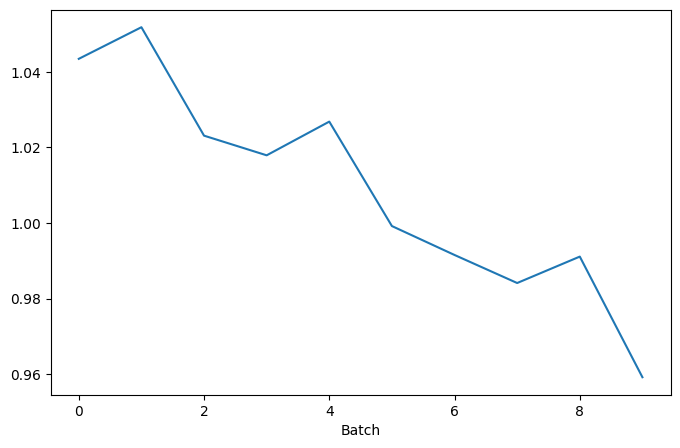

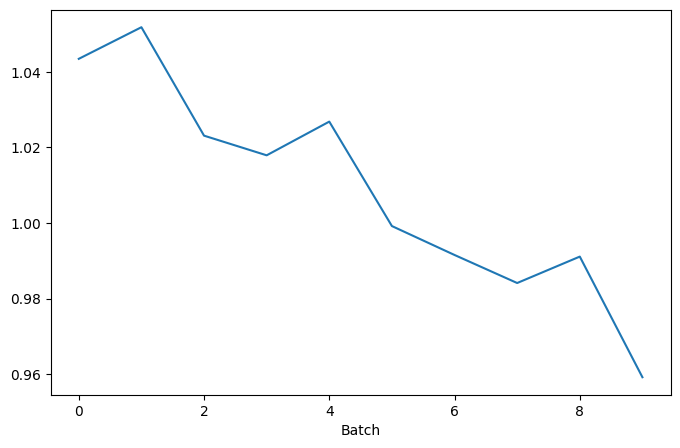

In [105]:
def trainCatModel(catModel, dataloader, epochs, embeddingModel, losses, PLOTUPDATES = True):
	updateRate = 10 # For plotting purposes

	loss_fn = nn.CrossEntropyLoss() #nn.MSELoss(reduction='sum')

	if PLOTUPDATES:
		fig, ax = plt.subplots(figsize=(8, 5))
	
	opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

	for epoch in range(epochs):
		
		for batch, labels in dataloader:

			timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

			noisyImgs = scheduler.addNoise(batch, timesteps)

			embeddings = embeddingModel(labels)

			pred = model(noisyImgs.to(device).float(), timesteps.to(device), embeddings.to(device))
			pred = F.softmax(pred, dim=1) 

			loss = loss_fn(pred, batch.to(device).argmax(axis=1)) 

			opt.zero_grad()
			loss.backward()
			opt.step()
			losses.append(loss.item())

		if PLOTUPDATES:
			if epoch % updateRate == 0:
				clear_output(wait=True)  
				ax.clear()
				plt.plot(losses)
				plt.xlabel('Batch')
				display(fig)
	
	if PLOTUPDATES:
		clear_output(wait=True)  
		ax.clear()
	plt.plot(losses)
	plt.xlabel('Batch')
	if PLOTUPDATES:
		display(fig)

	return catModel, losses

loss = []
catModel, loss = trainCatModel(model, loader, 10, transformer, loss)

In [44]:
# Test of Inference

testX = torch.randint_like(InitialDataset[0:1], high=1, low=0, device=device)  # [1, 4, 10, 10]
#testY = torch.randint_like(InitialLabels[0:1], high=2, low=0, device='cpu')  
testY = InitialLabels[0:1]
testY = transformer(testY).to(device)
#testY = transformer(InitialLabels[0:1]).to(device)


inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps // 64, device='cpu').long()

for t in inferenceSteps:
    with torch.no_grad():
        residual_cond = model(testX.to(device).float(), t, testY.float()) 
        
        residual = F.softmax(residual_cond, dim=1)
    testX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
testX = F.softmax(model(testX.to(device), 0, testY), dim=1)

#transformer


#model(testX, torch.tensor([199], device=device), testY)
outX = torch.argmax(testX, dim=1, keepdim=True).cpu().numpy().squeeze()

outX = outX.T
outX[0] = endColoumns
outX[-1] = endColoumns
outX = outX.T
outX

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
#from CircuitSimulation.CircuitSimulator import *
# now, simulate

inpSockets = [
    (Socket("inp0", True), (0, 0)), 
    (Socket("inp1", True), (0, 3)), 
    (Socket("inp2", True), (0, 6)), 
    (Socket("inp3", True), (0, 9)), 
]

outSockets = [  
	(Socket("out0", False), (9, 0)), 
    (Socket("out1", False), (9, 3)), 
    (Socket("out2", False), (9, 6)), 
    (Socket("out3", False), (9, 9)),
]

ins = inpSockets #short alias
orders = [ # as input indexes
	[0, 1],
]

socketMap, WireSets = GetSocketMap(outX, inpSockets + outSockets)
connectionMap = GetConnectionMap(socketMap)
#print(WireSets)	
#print(socketMap)
#print(connectionMap)

rows = []
for orderIndexes in orders:
	order = [ins[i][0] for i in orderIndexes]

	# try:
	output = Simulate(connectionMap, socketMap, order)

	outputs = [2] * 4 # initialize as unused
	for socket, state in output:
		prefix, compid, comptype = socket.name

		if prefix == "out":
			outputs[int(compid)] = int(state)

	row = [2] * 8
	for index in orderIndexes:
		row[index] = 1
	rows.append(row + outputs)


	for socket in socketMap.keys():
		socket.state = False

	print(output)
	# except Exception as e:
	# 	print(e)
print(rows)

[[1 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 3 3 0 0 0 0]
 [3 3 3 3 3 3 0 0 0 4]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 3 3 3 3 0 0]
 [5 5 5 5 0 0 0 3 3 3]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 7]]
{inp0: set(), inp1: {3}, inp2: {5}, inp3: set(), out0: set(), out1: set(), out2: {3}, out3: set()}
{3: [inp1, out2], 5: [inp2]}
[(inp0, True), (inp1, True), (inp2, False), (inp3, False), (out0, False), (out1, False), (out2, True), (out3, False)]
[[1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0]]


In [79]:
from matplotlib.colors import ListedColormap

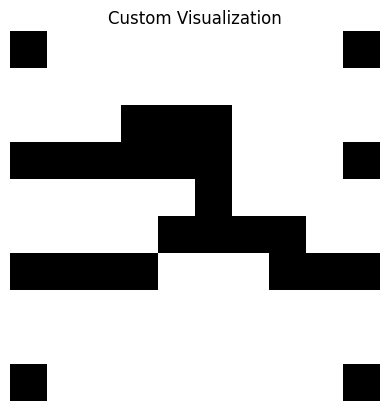

In [88]:
cmap = ListedColormap(['white', 'black', 'red', 'blue'])

plt.imshow(outX, cmap=cmap, vmin=0, vmax=3)
plt.title("Custom Visualization")
plt.axis('off')
plt.show()

# About pruning
# Connections with no associated components can be pruned
# Connections with only sources or only sinks can be pruned
# Components with no connections can be pruned (Under certain circumstances)

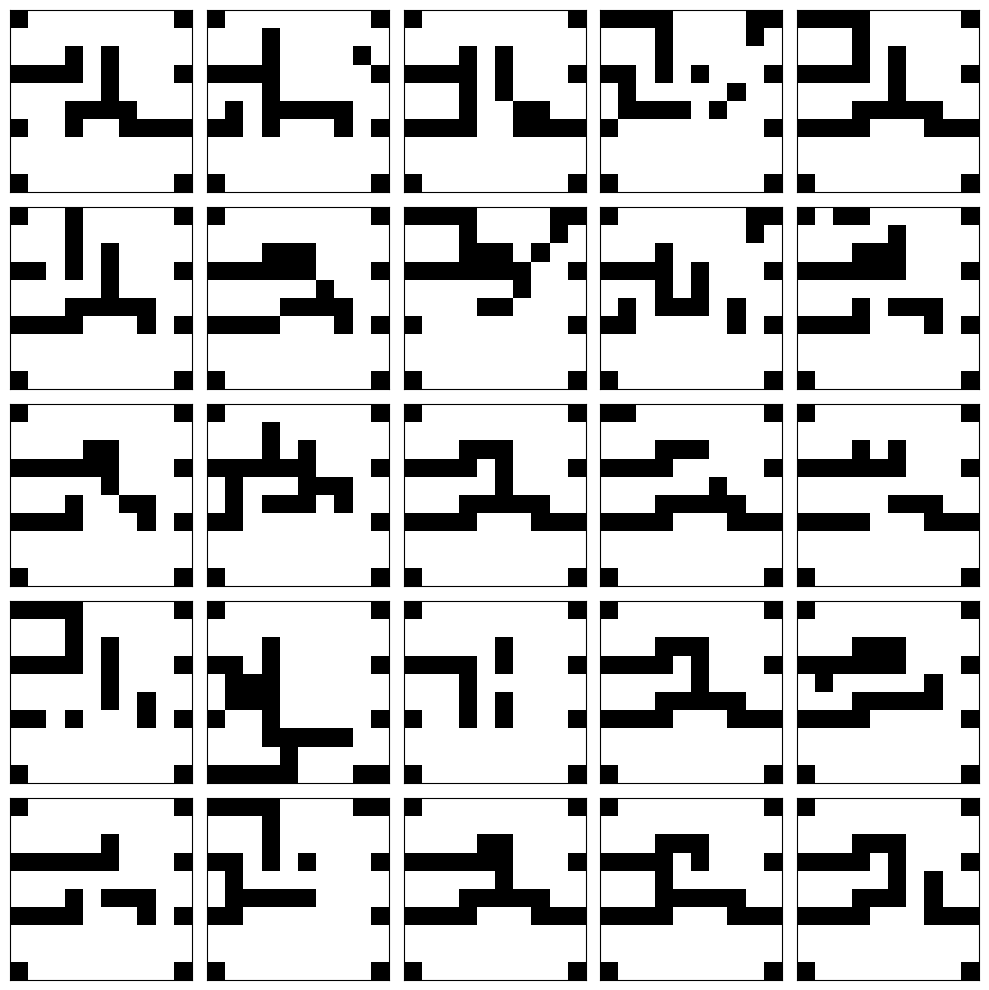

In [ ]:
batchSize = 25
batchX = torch.randint(size=(batchSize, 4, 10, 10), high=1, low = 0, device=device )
batchY = torch.randint(size=(batchSize, 4, 12), high = 2, low =0, device='cpu' )
batchY = transformer(batchY).to(device)

inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps // 64, device='cpu').long()

for t in inferenceSteps:
    with torch.no_grad():
        residual_cond = model(batchX.to(device).float(), t, batchY.float()) 
        
        residual = F.softmax(residual_cond, dim=1)
    batchX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
batchX = F.softmax(model(batchX.to(device), 0, batchY), dim=1)

outX = torch.argmax(batchX, dim=1).cpu().numpy().squeeze()  # Shape: [25, H, W]

for i in range(outX.shape[0]):
    img = outX[i].T
    img[0] = endColoumns
    img[-1] = endColoumns
    outX[i] = img.T
    
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for idx, ax in enumerate(axes.flat):
    ax.imshow(outX[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
def plot25(stepDivisor = 64, title = 'No Title'):
	batchSize = 25
	batchX = torch.randint(size=(batchSize, 4, 10, 10), high=1, low = 0, device=device )
	batchY = torch.randint(size=(batchSize, 4, 12), high = 3, low =0, device='cpu' )
	batchY = transformer(batchY).to(device)

	inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps // stepDivisor, device='cpu').long()

	for t in inferenceSteps:
		with torch.no_grad():
			residual_cond = model(batchX.to(device).float(), t, batchY.float()) 
			
			residual = F.softmax(residual_cond, dim=1)
		batchX = scheduler.addNoise(residual.to('cpu'), t - 1).float()
	batchX = F.softmax(model(batchX.to(device), 0, batchY), dim=1)

	outX = torch.argmax(batchX, dim=1).cpu().numpy().squeeze()  # Shape: [25, H, W]

	for i in range(outX.shape[0]):
		img = outX[i].T
		img[0] = endColoumns
		img[-1] = endColoumns
		outX[i] = img.T
		
	fig, axes = plt.subplots(5, 5, figsize=(10, 10))
	for idx, ax in enumerate(axes.flat):
		ax.imshow(outX[idx], cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
		ax.set_xticks([])
		ax.set_yticks([])

	fig.suptitle(title)

	plt.tight_layout()
	plt.show()
    
#plot25(64, "x Epochs")

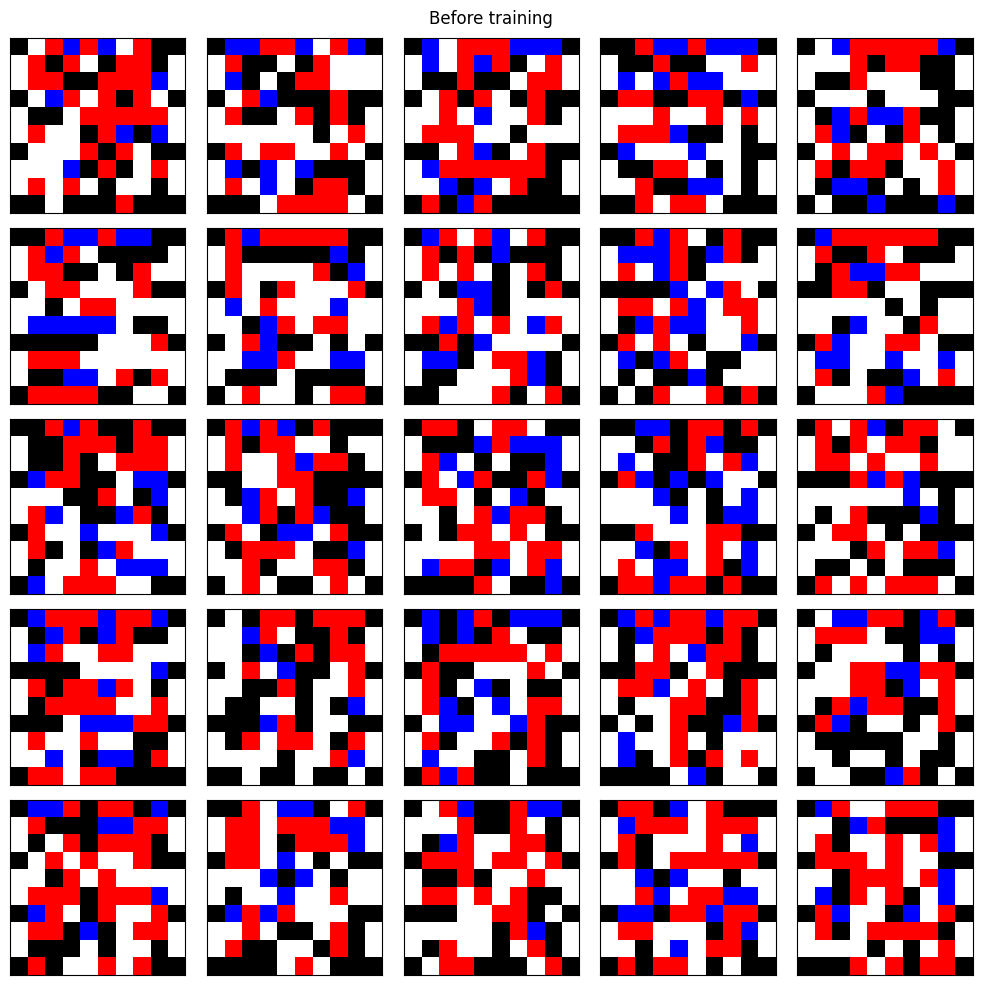

In [112]:
model = CategoricalDiffusionModel(10, 4, 16).to(device)

plot25(64, "Before training")

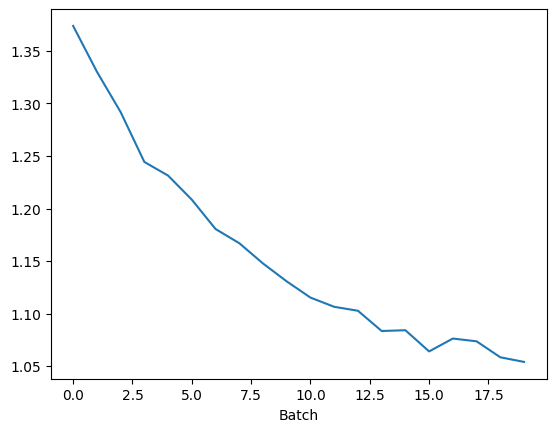

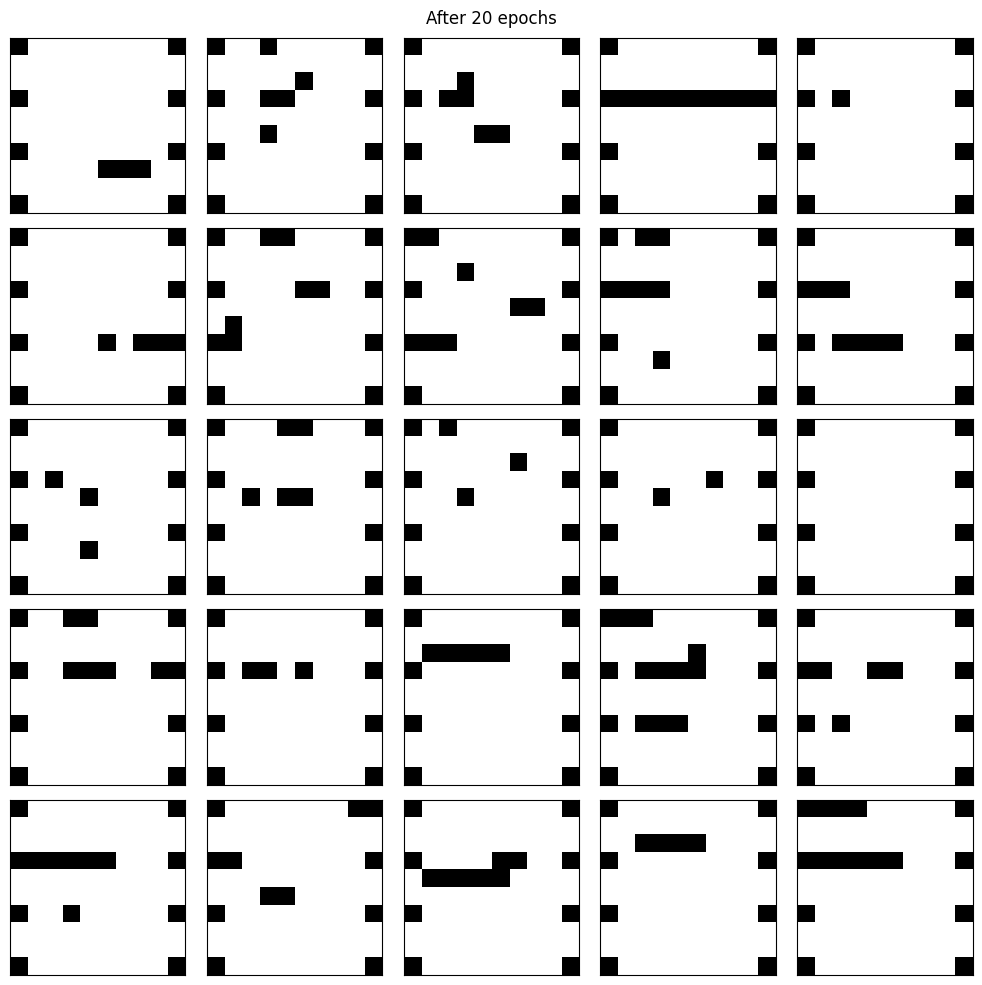

In [113]:
loss = []
catModel, loss = trainCatModel(model, loader, 20, transformer, loss, PLOTUPDATES=False)
plot25(64, "After 20 epochs")

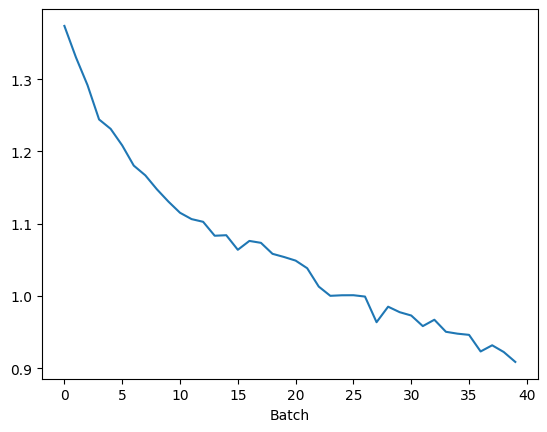

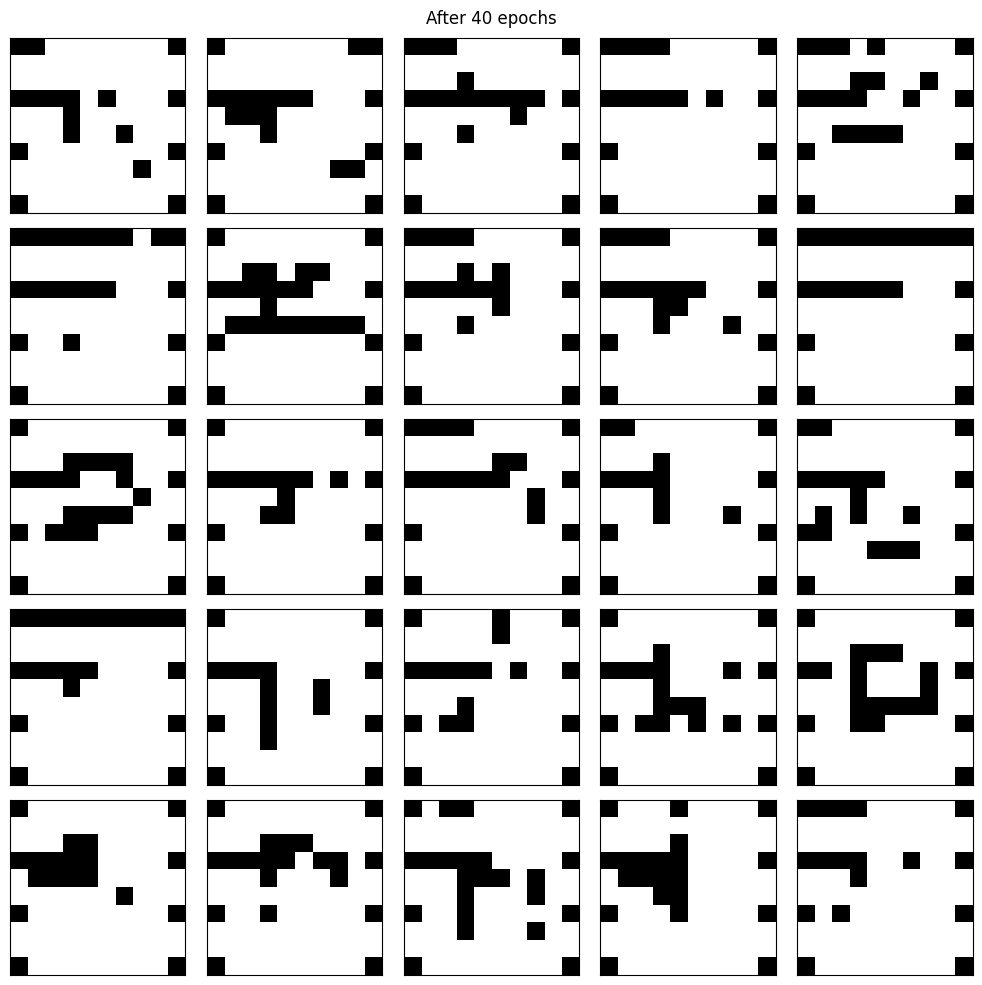

In [114]:
catModel, loss = trainCatModel(model, loader, 20, transformer, loss, PLOTUPDATES=False)
plot25(64, "After 40 epochs")

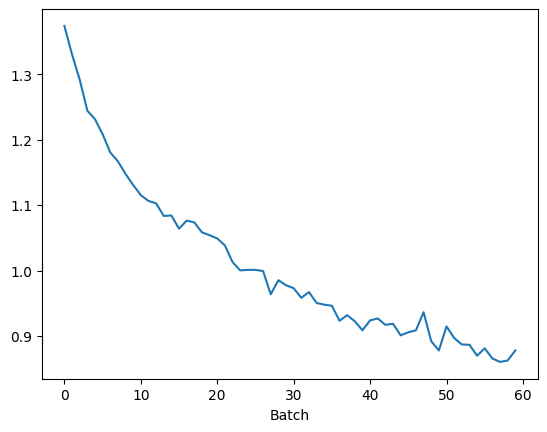

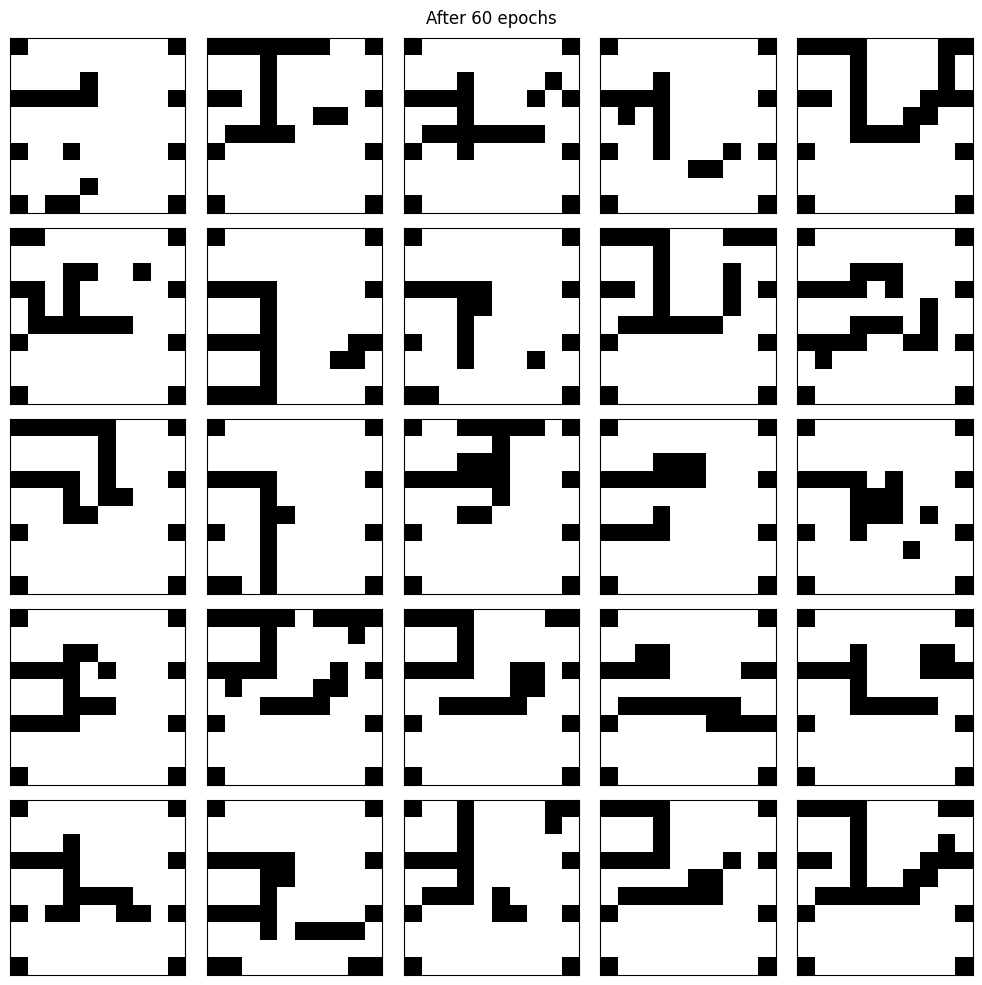

In [115]:
catModel, loss = trainCatModel(model, loader, 20, transformer, loss, PLOTUPDATES=False)
plot25(64, "After 60 epochs")

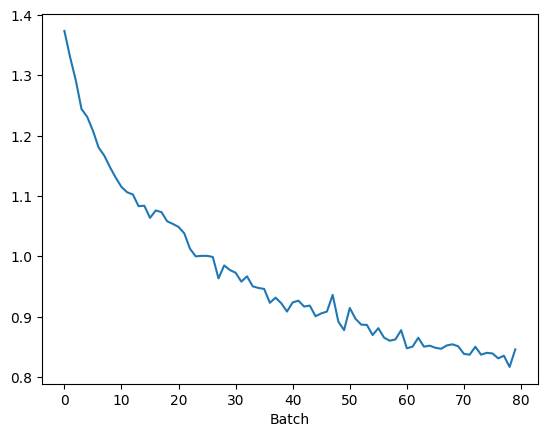

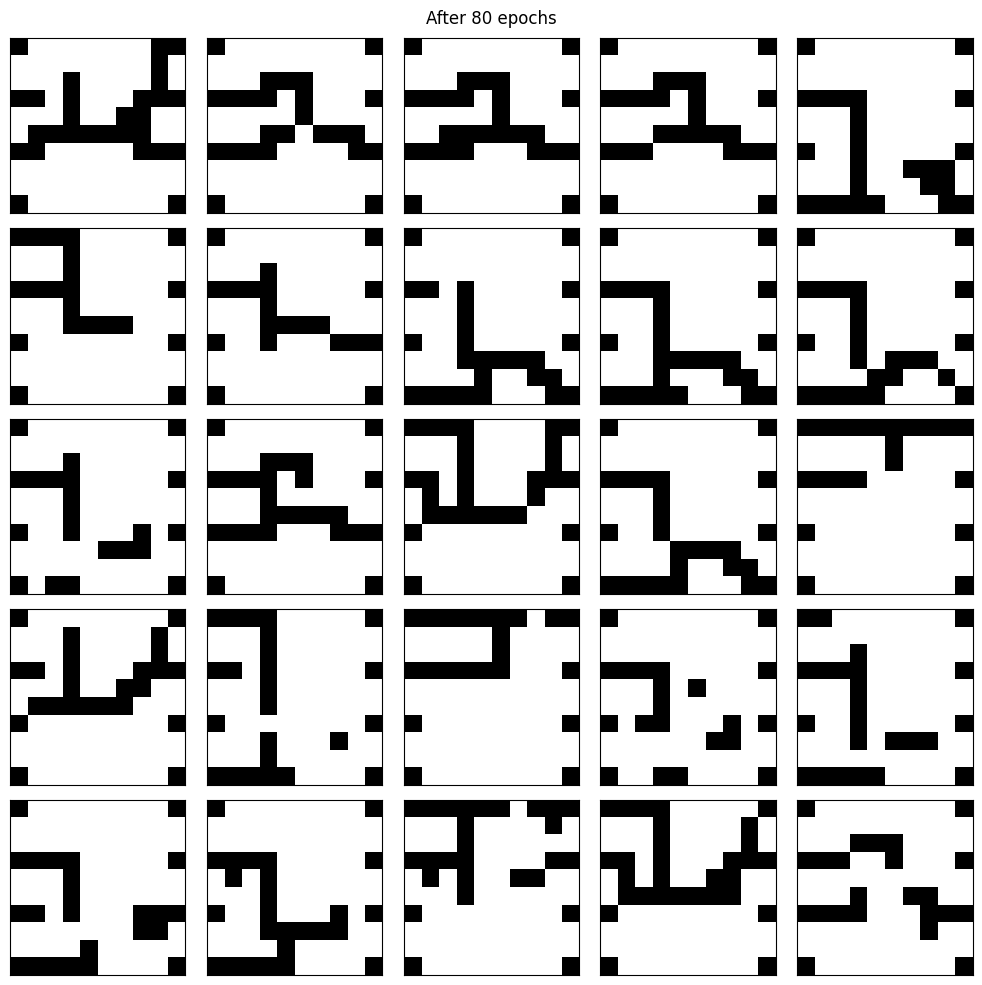

In [116]:
catModel, loss = trainCatModel(model, loader, 20, transformer, loss, PLOTUPDATES=False)
plot25(64, "After 80 epochs")

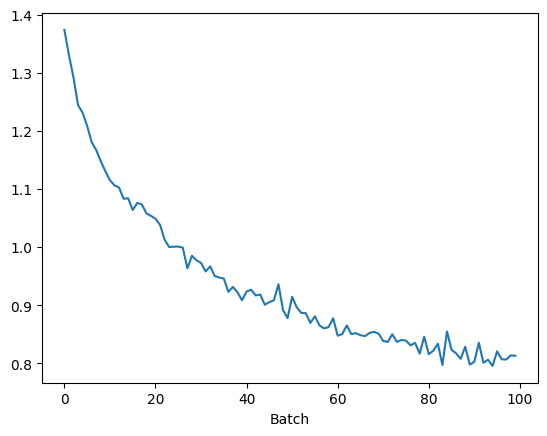

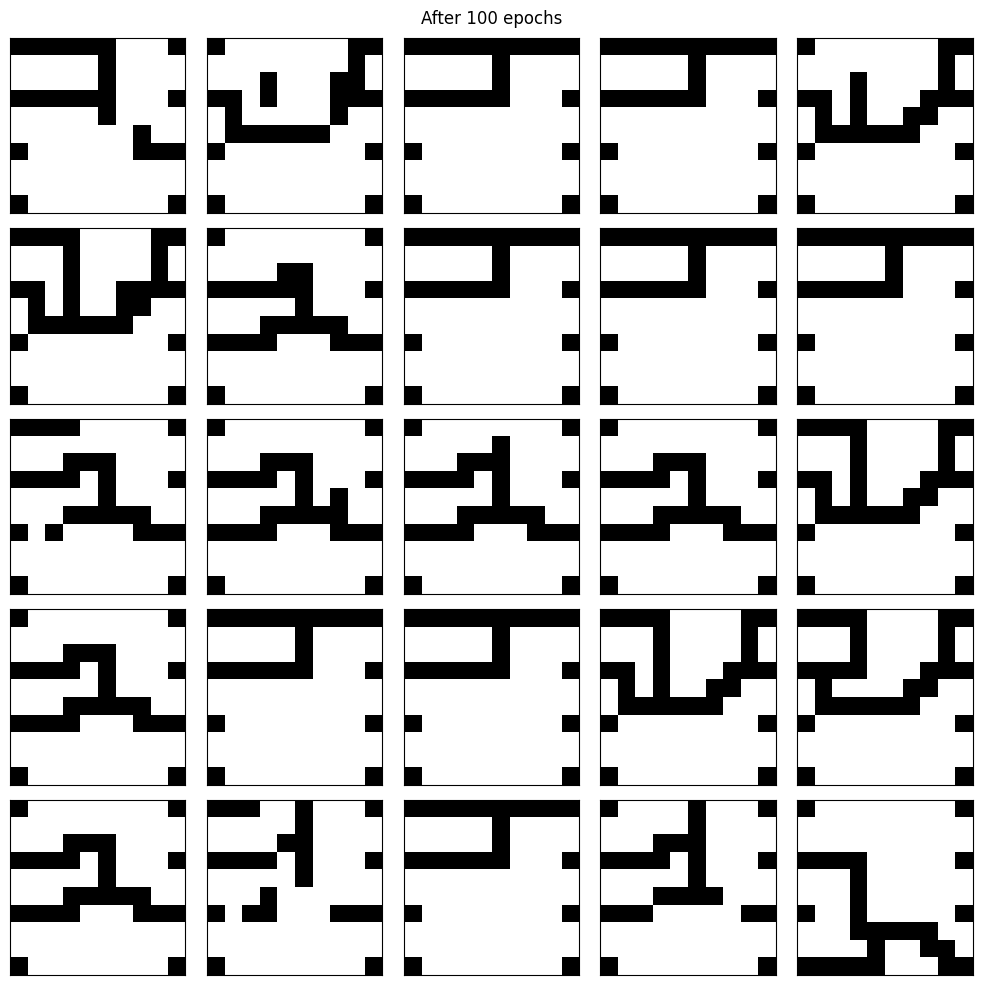

In [117]:
catModel, loss = trainCatModel(model, loader, 20, transformer, loss, PLOTUPDATES=False)
plot25(64, "After 100 epochs")

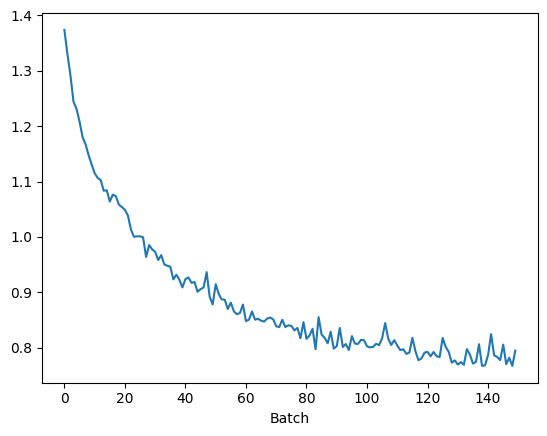

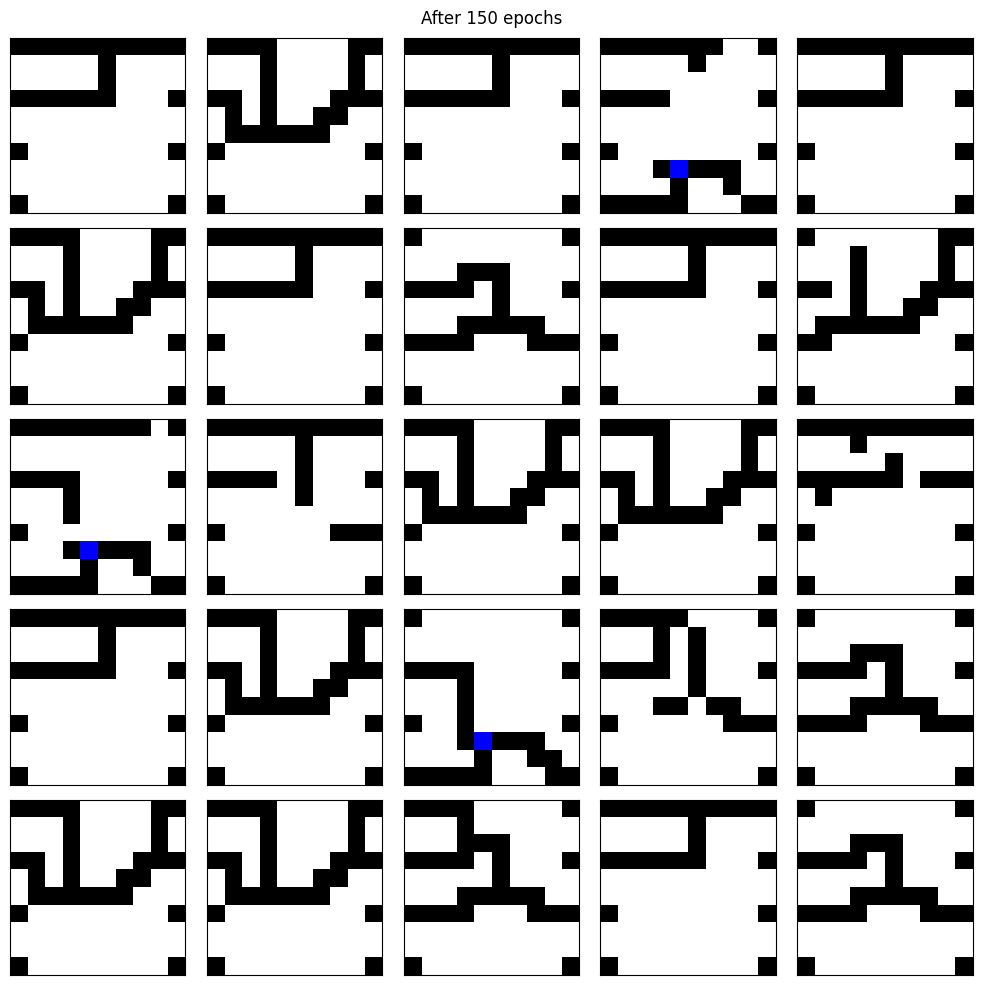

In [118]:
catModel, loss = trainCatModel(model, loader, 50, transformer, loss, PLOTUPDATES=False)
plot25(64, "After 150 epochs")

Middle column got a real circuit, but it is a copy of one of the samples

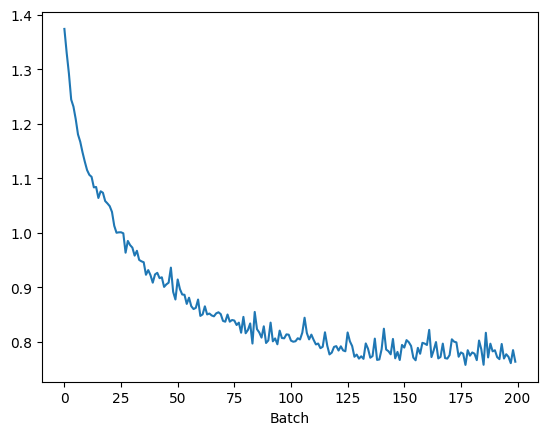

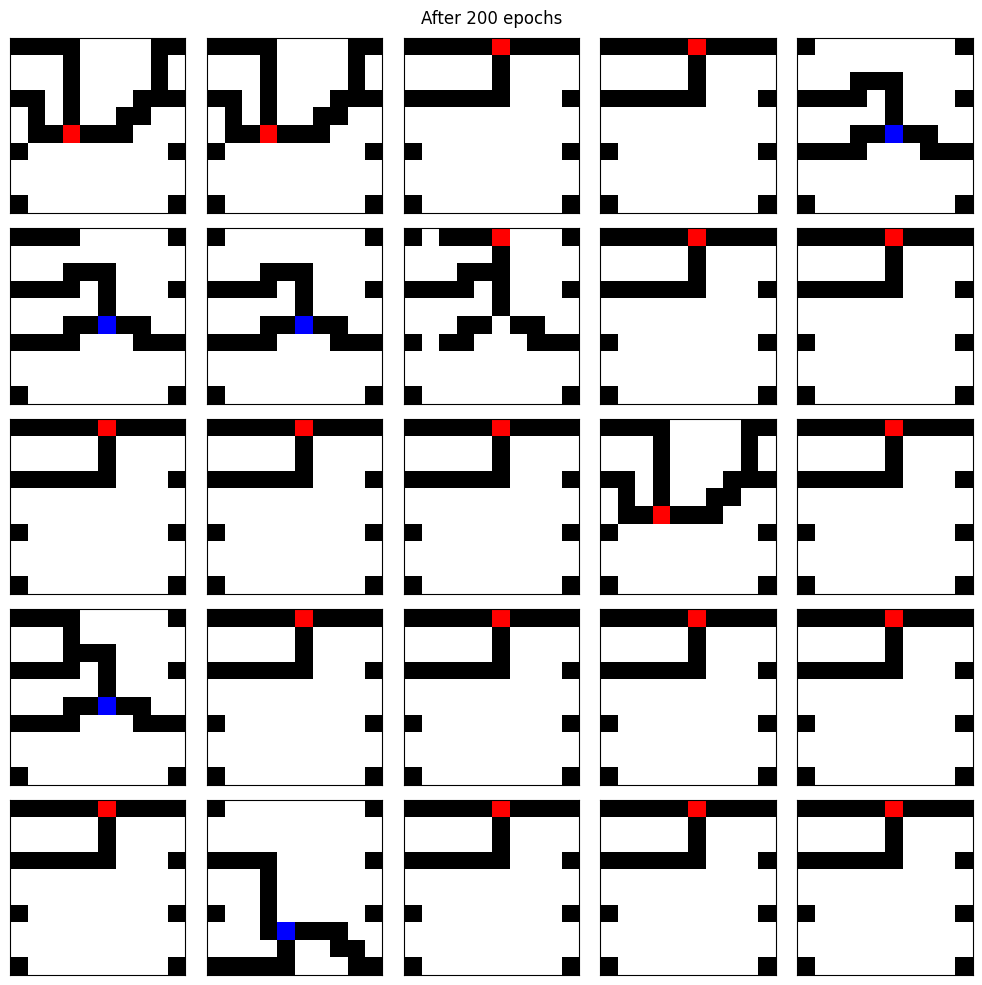

In [119]:
catModel, loss = trainCatModel(model, loader, 50, transformer, loss, PLOTUPDATES=False)
plot25(64, "After 200 epochs")

There are some novel versions above. like the first one, and first in fourth row. no, nevermind. the first one is a result of one of the samples having the endcolumns added

Will novelty keep dropping as training continues?

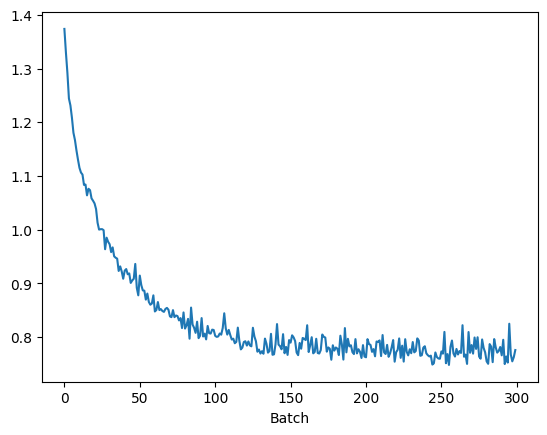

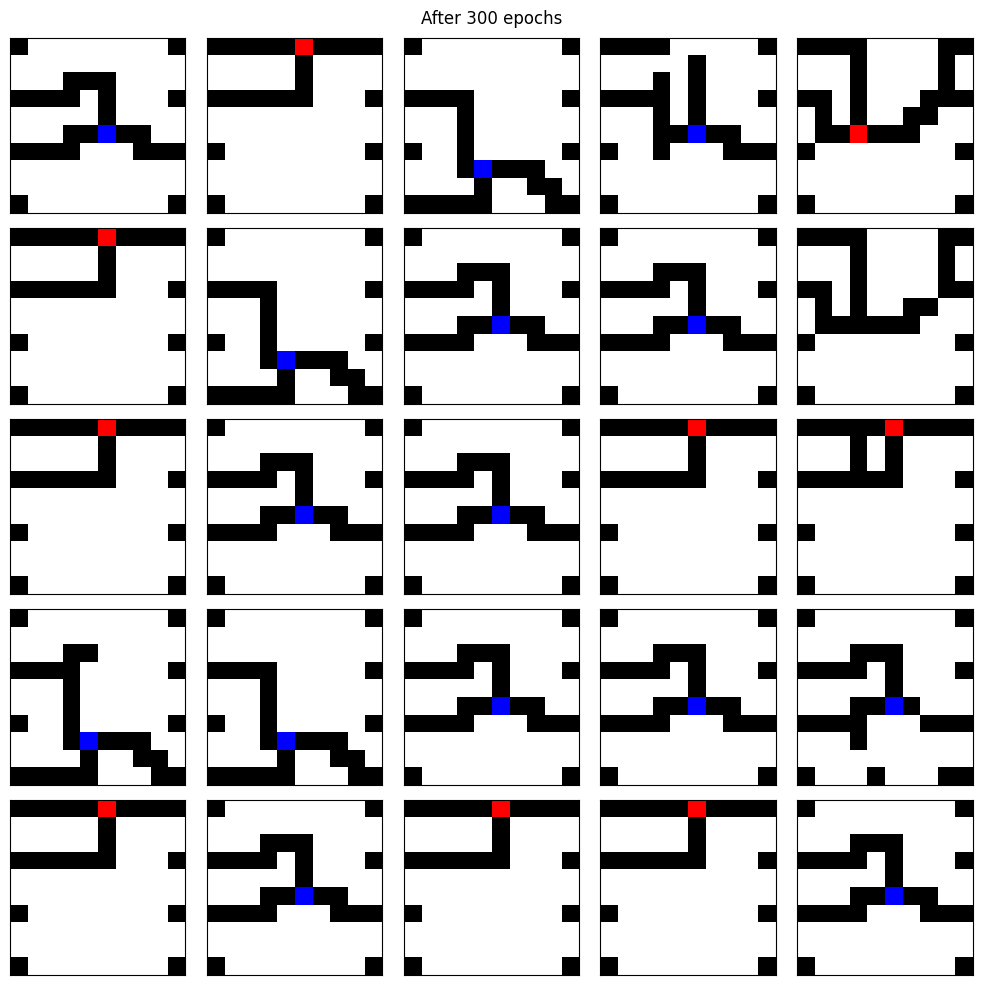

In [120]:
catModel, loss = trainCatModel(model, loader, 100, transformer, loss, PLOTUPDATES=False)
plot25(64, "After 300 epochs")

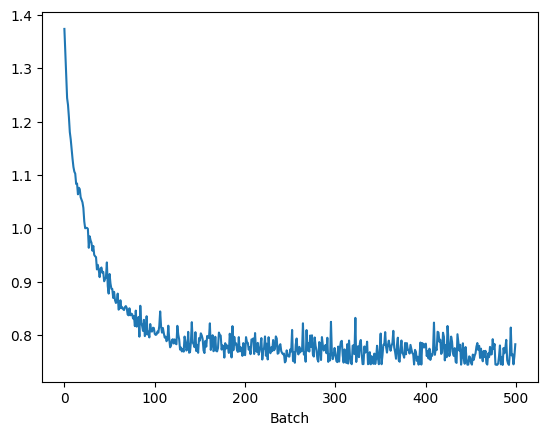

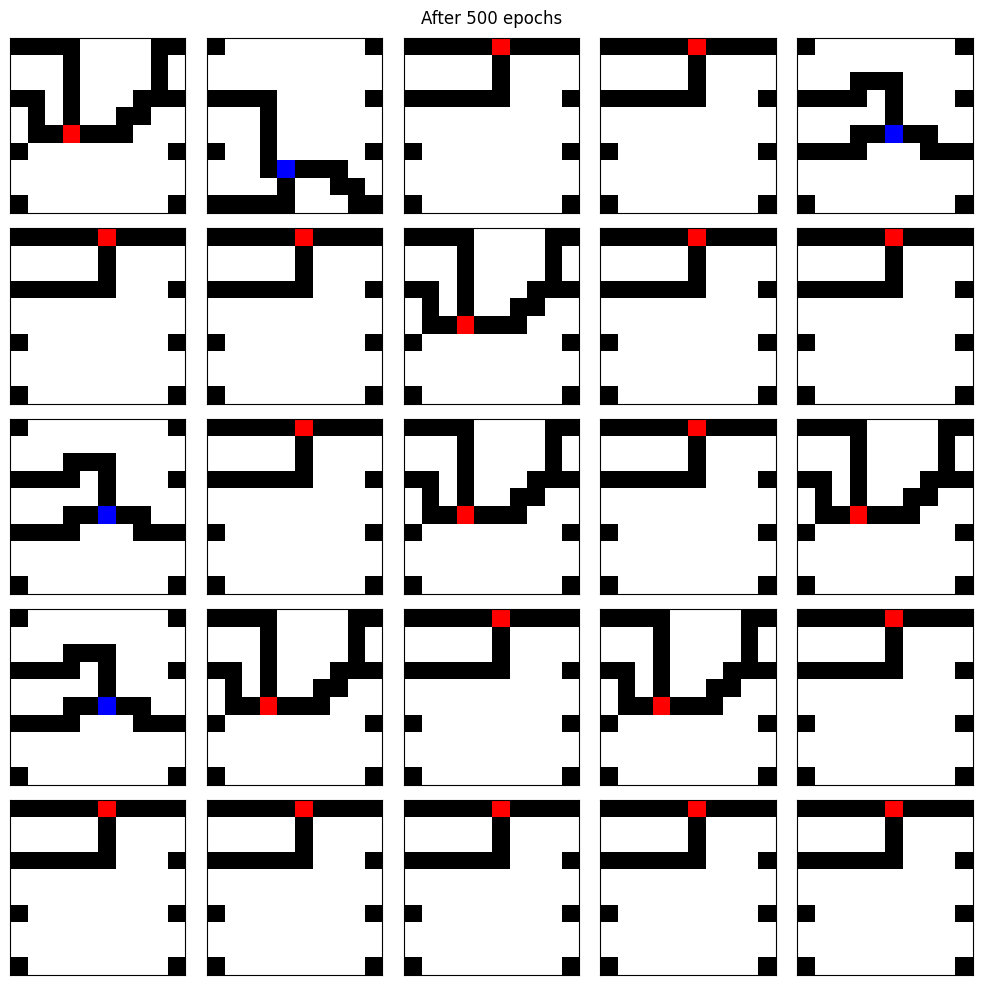

In [121]:
catModel, loss = trainCatModel(model, loader, 200, transformer, loss, PLOTUPDATES=False)
plot25(64, "After 500 epochs")

# results

Indeed initial generations  will be unusable while generations after training for a long time lack in novelty.

This lack in novelty will likely be inhibited by having much more diverse training data

This did succeed in making 1 new possible addition to the dataset

# Questions.

Should i change this to not include memory from having out0-3 as inputs? Yes, it would be very cool if this method could produce circuits that can store and use values. Even a simple incrementer would be an incredible discovery.
But, i'm not sure how i with code would take an image of the circuit and get the 'output before state'

Other problem, for simplicity i just did this with 4 rows of a truth table, but this should have up to 16 rows, with only each possible input.
The network does not specify how many rows the embedding has. Would it be fine to use only relevant rows, which would sometimes be less than 16? or should i just stick to having a lot of rows that are entirely 2's?

# What should i do from here?

1. Measure, the generations for how good the model is at generating successful circuits, and novel circuits.
2. Find the point where the amount of useful circuits is maximized.
3. Do a bunch of stuff to add those circuits and then, Profit?


# What do i wanna do?

Though memory would clearly signify that this method could learn out of distribution data, and train on it. But before training on that sort of data, it would first need to generate it. That is, until a circuit makes use of the 4 output inputs, they would not influence the training, and when it does make a sample that uses it, that would be the result I am hoping for.

So, I will proceed with removing the output inputs for now. Adding them back again later, would be a smaller change, and the network would have to be retrained.

Ok, so now.
1. I want to time how long each part takes.
2. I want to measure the success and novelty rate of the model at every some epochs.
3. I will continue planning from there, but goal is still to train a model.